In [1]:
import os

import numpy as np
import pandas as pd 
import numpy as np
from fastai import *
from fastai.vision import *
import torch
import torch.nn as nn
import torchvision
from torchvision.models import *
import cv2
from sklearn.metrics import roc_auc_score

from utils import *

In [2]:
DATA_DIRECTORY = '../../../../licenta/data'
TRAIN_LABELS =  DATA_DIRECTORY + "/train_labels.csv"
SUBMISSION_LABELS = DATA_DIRECTORY + "/sample_submission.csv"
SIZE = 96
BATCH_SIZE = 64

In [3]:
train_labels = pd.read_csv(TRAIN_LABELS)

In [4]:
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1, max_lighting=0.05, max_warp=0.)

In [5]:
data = ImageDataBunch.from_csv(DATA_DIRECTORY,csv_labels='train_labels.csv',folder='train',
                               ds_tfms=transforms, size=SIZE, suffix='.tif',test='test',bs=BATCH_SIZE)

In [6]:
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: ..\..\..\..\licenta\data;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,1,0,0,0
Path: ..\..\..\..\licenta\data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ..\..\..\..\licenta\data

In [7]:
model = cnn_learner(data,densenet201,path='.',metrics=[auc_score], ps=0.8)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\diana/.cache\torch\checkpoints\densenet201-c1103571.pth


In [8]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


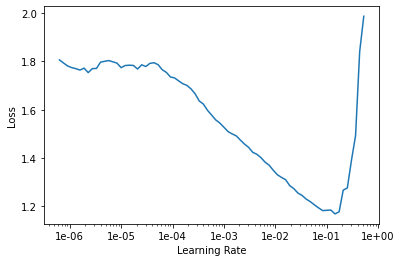

In [9]:
model.recorder.plot()

In [9]:
learning_rate = 3e-03
model.fit_one_cycle(1,learning_rate)

In [11]:
model.unfreeze()

In [12]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [13]:
model.recorder.plot()

In [14]:
model.fit_one_cycle(1,slice(1e-6,1e-5))

In [16]:
y_score,y_true = model.get_preds()
prediction_score = auc_score(y_score,y_true)
print(prediction_score)

tensor(0.9881, dtype=torch.float64)


In [17]:
y_test_score,y_test_true = model.get_preds(ds_type=DatasetType.Test)

In [18]:
submission=pd.read_csv(SUBMISSION_LABELS).set_index('id')

In [19]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items).astype(str)

In [20]:
submission.loc[fname_cleaned,'label']=to_np(y_test_score[:,1])
submission.to_csv('submission.csv')